# Homework 4

- Execute the below code, then answer the numbered questions.

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [2]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [3]:
# insert code here
numerical_features = [feature for feature in features if df.dtypes[feature] in ['float64', 'int64']]
categorical_features = [feature for feature in features if df.dtypes[feature] in ['object']]

## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [4]:
# insert code here
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
    ('replace_missing_values', SimpleImputer(strategy='median')),
    ('standard_scaler', StandardScaler())
])

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [5]:
# insert code here
from sklearn.preprocessing import OneHotEncoder

categorial_pipeline = Pipeline([
    ('replace_missing_values', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

categorial_data = X_train[categorical_features]
categorial_data_transformed = categorial_pipeline.fit_transform(categorial_data)

columns = categorial_pipeline['one_hot_encoder'].get_feature_names_out()
categorial_data_transformed = pd.DataFrame(categorial_data_transformed.toarray(), columns=columns)

transformed_data = pd.concat([categorial_data_transformed, X_train[numerical_features]], axis=1)

print(transformed_data)
print(transformed_data.shape[1])


      x0_chevrolet  x0_chrysler  x0_dodge  x0_ford  x0_honda  x0_hyundai  \
0              0.0          0.0       0.0      0.0       0.0         0.0   
1              0.0          1.0       0.0      0.0       0.0         0.0   
2              0.0          0.0       0.0      1.0       0.0         0.0   
3              0.0          0.0       0.0      0.0       1.0         0.0   
4              0.0          0.0       0.0      0.0       0.0         1.0   
...            ...          ...       ...      ...       ...         ...   
9047           NaN          NaN       NaN      NaN       NaN         NaN   
9048           NaN          NaN       NaN      NaN       NaN         NaN   
9050           NaN          NaN       NaN      NaN       NaN         NaN   
9053           NaN          NaN       NaN      NaN       NaN         NaN   
9054           NaN          NaN       NaN      NaN       NaN         NaN   

      x0_kia  x0_nissan  x0_toyota  x1_manual  ...  x2_sc  x2_tn  x2_tx  \
0        1.0

## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [6]:
# insert code here
from sklearn.compose import ColumnTransformer

preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorial', categorial_pipeline, categorical_features)
])

transformed_data = preprocessing_pipeline.fit_transform(X_train)
transformed_data = pd.DataFrame(transformed_data.toarray())
missing_values_count = transformed_data.isnull().sum().sum()
print(f'Number of missing values: {missing_values_count}')
print(f'Transformed data shape: {transformed_data.shape}')
print(f'Correct number of columns: {transformed_data.shape[1]}')

Number of missing values: 0
Transformed data shape: (7244, 44)
Correct number of columns: 44


## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [7]:
# insert code here
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('linear_regression', LinearRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R^2 score: {r2}')

R^2 score: 0.8838274420792979


## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

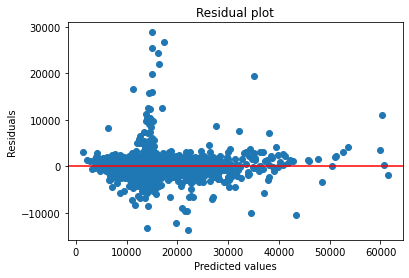

In [8]:
# insert code here
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()


As visible from the plot, there are a lot of outliers around the area where the predicted value is between 10000 and 20000. It seems a non-linear model would fir better for the dataset.

## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [9]:
# insert code here
from sklearn.linear_model import Ridge

model = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('ridge_regression', Ridge(alpha=100))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R^2 score: {r2}')


R^2 score: 0.8824295262289474


The ridge model almost has the same R^2 score (slightly less) than the linear regression model.